# Bounding Box Recursive Frisch Scheme

This code implements a novel recursive linear estimator based on the Frisch scheme.

In the first part, the functionality of the code is tested performing a single estimation.

The cosidered model is: $x_3 = -(1.5x_1 + 1.2x_2$)

where $x_1$ and $x_2$ are generated from indipendent zeror-mean Gaussian distributions with the numpy function "np.random.randn()"

Then, a Monte Carlo simulation is performed where the seed used to generate the variable is changed. The results are averaged, finding also the mininum and the maximum values among all the Monte Carlo runs.

A detailed list of the custom functions implemented in this code is available in the README.txt file

In [ ]:
%matplotlib notebook
#
from scipy import linalg, matrix
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from tqdm import tqdm_notebook as tqdm
from matplotlib2tikz import save as tikz_save
#
import numpy as np
import scipy
import time
import BBRFcommon as com
import matplotlib.pyplot as plt

# Setup Simulation

In [2]:
m = 20                        # Observation matrix width
N = m*int(1e6)                # Total number of Samples
n = 2                         # Number of Parameters
par = np.array([[1.5],[1.2]]) # Nominal Paramter Vector
delta = 0.3                   # Noise/Signal ratio (standard dev)



#### SINGLE ESTIMATION

In [3]:
###### GENERATE SIMULATION DATA
# Generate Data
X = []
X = com.Gen_noiseless(N,n,1,par)
# Generate Noise
#X = com.Add_noise(N,n,1,delta,X)
var = delta*np.diag(np.matmul(np.transpose(X),X)/N)
Sn = np.diag(var)
# Compute Total Simplex
Stot = np.matmul(np.transpose(X),X)/N + Sn
Atot = np.transpose(com.OLS(Stot,n))
#

In [4]:
# Perform BOUNDING-BOX RECURSIVE FRISCH SCHEME estimation 
x,y,L,U,t = com.BBRF(X,Sn,N,n,m)
print(t)

523.2056994438171


#### Data Analysis

In [5]:
######### Volumes ############################################
# Volume of the Solution box
Vb = (U[:,1]-L[:,1])*(U[:,0]-L[:,0]) 
# Volume of the total simplex
Vtot = com.simvol(Atot,n)
# Volume of the simplices at different itarations
Vit = np.zeros((int(N/m),1))
for i in range(0,int(N/m)):
    Ait = np.transpose([x[i],y[i]])
    Vit[i] = com.simvol(Ait,n)

<IPython.core.display.Javascript object>


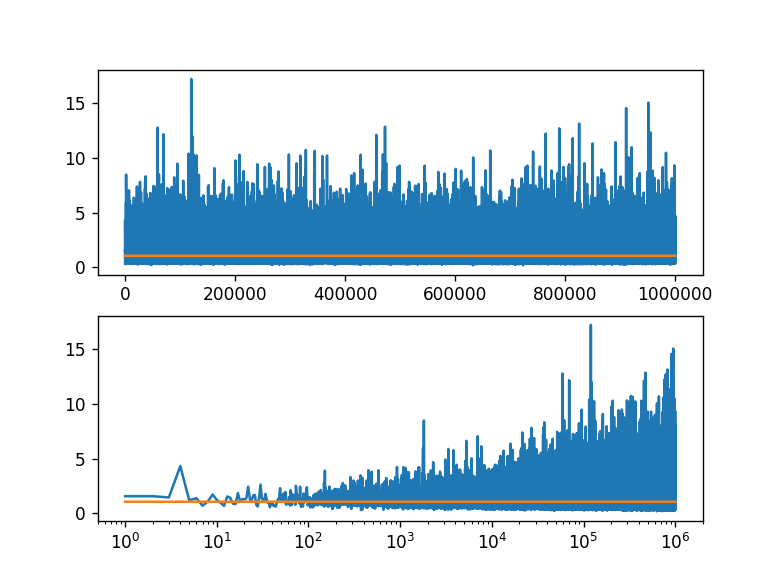

In [6]:
# plot volumes (standard and log)
plt.figure()
it = np.linspace(1,N/m,int(N/m))
Vtotit = Vtot*np.ones((int(N/m),1))
plt.subplot(211)
plt.plot(it,Vit)
plt.plot(it,Vtotit)
plt.subplot(212)
plt.semilogx(it,Vit)
plt.semilogx(it,Vtotit)

#### Plot Results

In [7]:
# Setup MATPLOTLIB
# Latex font for plots (doesn't work on linux)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

# Iteration Vector
it = np.linspace(1,N/m,int(N/m))

<IPython.core.display.Javascript object>


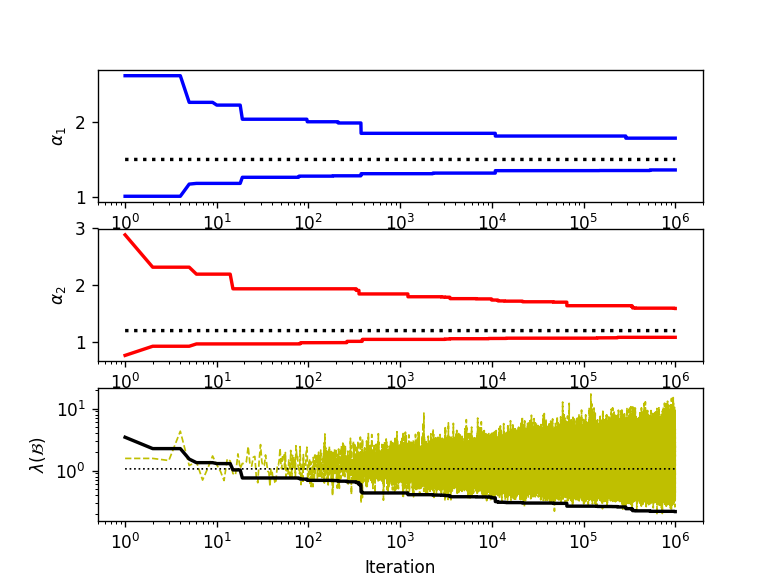

In [8]:
# Time evolution of bounds
parit = np.transpose(par).tolist()*np.ones((int(N/m),2))
Vtotit = Vtot*np.ones((int(N/m),1))
#
plt.figure()
#
plt.subplot(311)
plt.semilogx(it,L[1:,0], color='b', lw=2)
plt.semilogx(it,U[1:,0], color='b', lw=2)
plt.semilogx(it,parit[:,0],color='k', lw=2,linestyle='dotted')
plt.ylabel(r"$\alpha_1$")
#
plt.subplot(312)
plt.semilogx(it,L[1:,1], color='r', lw=2)
plt.semilogx(it,U[1:,1], color='r', lw=2)
plt.semilogx(it,parit[:,1],color='k', lw=2,linestyle='dotted')
plt.ylabel(r"$\alpha_2$")
#
plt.subplot(313)
plt.loglog(it,Vit,color='y', lw=1,linestyle='dashed')
plt.loglog(it,Vb[1:], color='k', lw=2)
plt.loglog(it,Vtotit,color='k', lw=1,linestyle='dotted')
plt.ylabel(r"$\lambda(\mathcal{B})$")
#
plt.xlabel(r"Iteration")
#
plt.show()

<IPython.core.display.Javascript object>


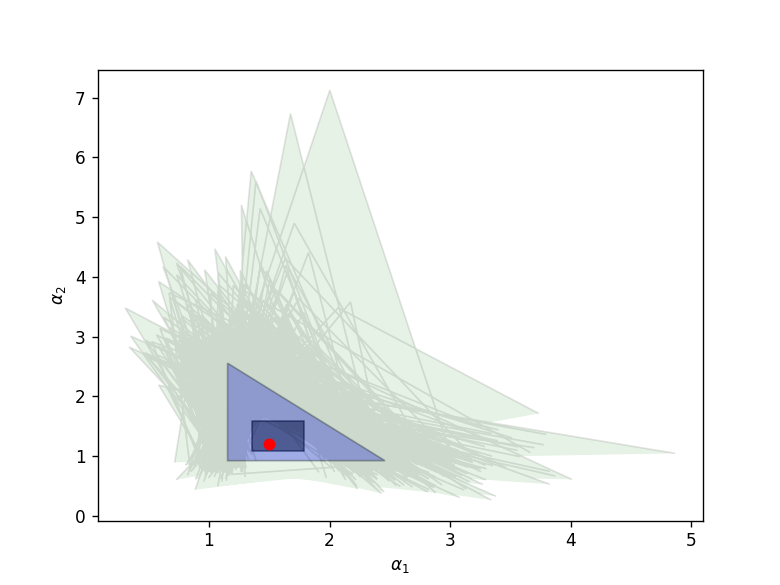

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [9]:
# Plot the simplices, the total simplex and the solution's box
x = np.array(x)
y = np.array(y)
xs = np.vstack((com.logsparse(x[:,0]),com.logsparse(x[:,1]),com.logsparse(x[:,2]))).T.tolist()
ys = np.vstack((com.logsparse(y[:,0]),com.logsparse(y[:,1]),com.logsparse(y[:,2]))).T.tolist()
xlist = []
ylist = []
for xtips,ytips in zip(xs,ys):
    xlist.extend(xtips)
    xlist.append(None)
    ylist.extend(ytips)
    ylist.append(None)
#
l = L[-1,:].tolist()
u = U[-1,:].tolist()
#
plt.figure()
plt.fill_between([l[0],u[0]],[l[1],l[1]],[u[1],u[1]], facecolor='k',alpha=0.5,edgecolor='k')
plt.fill(Atot[:,0],Atot[:,1],facecolor='b', alpha = .3, edgecolor='k')
plt.plot(par[0],par[1], color = 'r',marker='o')
plt.fill(xlist,ylist,facecolor='g',alpha=0.1,edgecolor='k')
plt.xlabel(r"$\alpha_1$")
plt.ylabel(r"$\alpha_2$")
#
tikz_save('intersection.tex')

## Fixed Monte Carlo:
### (Monte Carlo Simulation for fixed observation matrix height ($m$) and noise ($\delta$))

In [10]:
# Setup and perform Monte Carlo Sim
m = 20             # height of observation matrix
N_mc = 150          # number of Monte Carlo runs
N = m*int(1e6)
Data = com.BBRFmc_fix_par(N_mc,N,n,m,delta,par,6) # parallelized code (CPU)
#Data = com.BBRFmc_fix(N_mc,N,n,m,delta,par)      # Non paraellelized version or the Monte Carlo (Runs on a single thread)

In [11]:
# Analize the data 
Lavg,Uavg,Lmin,Umin,Lmax,Umax,Vavg,Vmin,Vmax,Vitavg,Vitmin,Vitmax,Vtotavg,Vtotmin,Vtotmax = com.DPfix(Data,n,N_mc)

(1000000,) (1000001,)


<IPython.core.display.Javascript object>


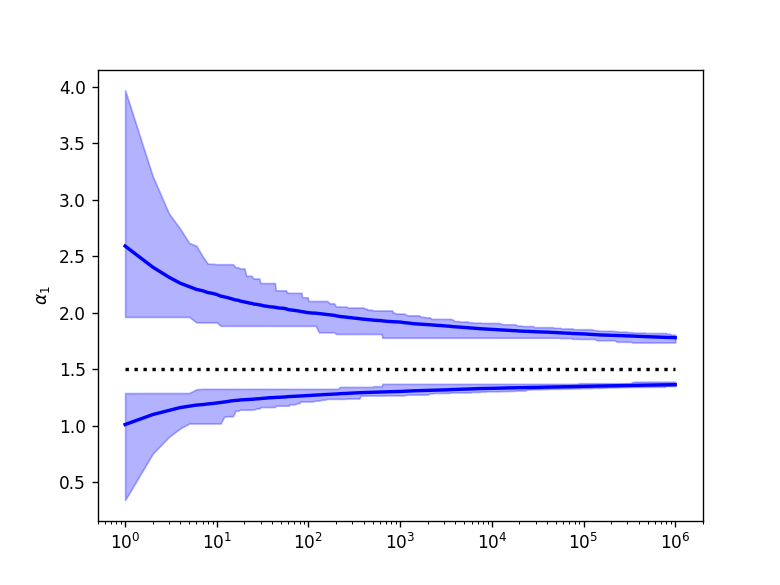

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


<IPython.core.display.Javascript object>


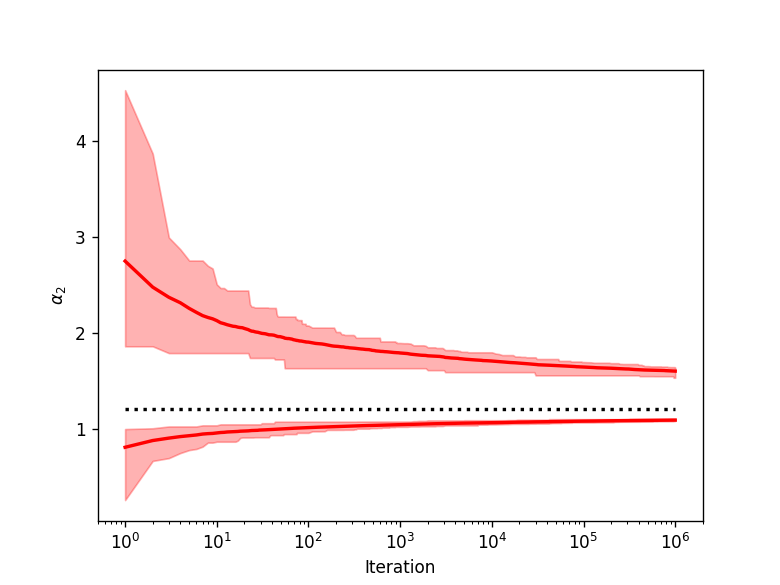

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [12]:
Lavgs = np.vstack((com.logsparse(Lavg[1:,0]),com.logsparse(Lavg[1:,1]))).T
Lmins = np.vstack((com.logsparse(Lmin[1:,0]),com.logsparse(Lmin[1:,1]))).T
Lmaxs = np.vstack((com.logsparse(Lmax[1:,0]),com.logsparse(Lmax[1:,1]))).T
#
Uavgs = np.vstack((com.logsparse(Uavg[1:,0]),com.logsparse(Uavg[1:,1]))).T
Umins = np.vstack((com.logsparse(Umin[1:,0]),com.logsparse(Umin[1:,1]))).T
Umaxs = np.vstack((com.logsparse(Umax[1:,0]),com.logsparse(Umax[1:,1]))).T
#
its = com.logsparse(it)
parits = np.vstack((com.logsparse(parit[:,0]),com.logsparse(parit[:,1]))).T

plt.figure()
#
#plt.subplot(211)
plt.semilogx(its,Lavgs[:,0], color='b', lw=2)
plt.semilogx(its,Uavgs[:,0], color='b', lw=2)
plt.semilogx(its,parits[:,0],color='k', lw=2,linestyle='dotted')
#
plt.fill_between(its, Lmins[:,0], Lmaxs[:,0], color='blue', alpha='0.3')
plt.fill_between(its, Umins[:,0], Umaxs[:,0], color='blue', alpha='0.3')
plt.ylabel(r"$\alpha_1$")
#
tikz_save("bounds1.tex")
############
plt.figure()
#
#plt.subplot(212)
plt.semilogx(its,Lavgs[:,1], color='r', lw=2)
plt.semilogx(its,Uavgs[:,1], color='r', lw=2)
plt.semilogx(its,parits[:,1],color='k', lw=2,linestyle='dotted')
#
plt.fill_between(its, Lmins[:,1], Lmaxs[:,1], color='red', alpha='0.3')
plt.fill_between(its, Umins[:,1], Umaxs[:,1], color='red', alpha='0.3')
plt.ylabel(r"$\alpha_2$")
plt.xlabel(r"Iteration")
#
plt.show()
#
tikz_save("bounds2.tex")

<IPython.core.display.Javascript object>


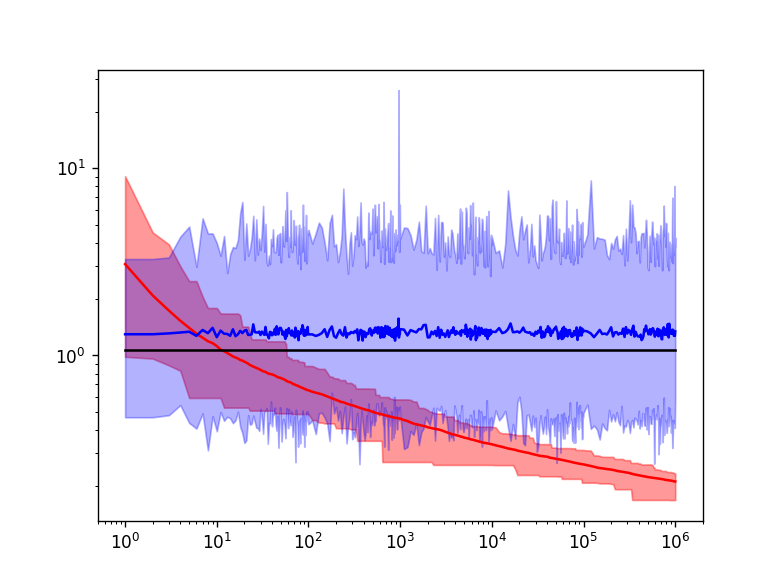

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [13]:
# Make data more sparse (for the sake of readability of the plot)
its = com.logsparse(it)
Vavgs = com.logsparse(Vavg[1:])
Vmins = com.logsparse(Vmin[1:])
Vmaxs = com.logsparse(Vmax[1:])
#
Vitavgs = com.logsparse(Vitavg)
Vitmins = com.logsparse(Vitmin)
Vitmaxs = com.logsparse(Vitmax)
#
# Plot solutions space volumes
Vtotits = Vtotavg*np.ones((its.shape[0],1))
#Vtotits = com.logsparse(Vtotit)

plt.figure()
plt.loglog(its,Vavgs, color='r')
plt.fill_between(its, Vmins, Vmaxs, color='red', alpha='0.4')
# Nonsparse plots 
#plt.loglog(it,Vitavg, color='b')
#plt.fill_between(it, Vitmin, Vitmax, color='blue', alpha='0.3')
# Sparse plots
plt.loglog(its,Vitavgs, color='b')
plt.fill_between(its, Vitmins, Vitmaxs, color='blue', alpha='0.3')
plt.loglog(its,Vtotits, color='k')

#
tikz_save('vol.tex')

### Test on Dimensionality

In [14]:
m = 500
dim = np.linspace(0,100,101)
dim = dim[3:]
N = int(1e4)
Ndim = dim.shape[0]
print('We we check the computation time for the following # of variables')
print(dim)
T = []
for i in tqdm(range(Ndim)):
    d = int(dim[i])
    par = np.random.randn(d-1,1)#np.linspace(d-1,1,d-1)
    U = np.random.randn(N,d-1) # Define Input
    y = U.dot(par) # Compute output
    X = np.hstack((U,y)) # Def OBSERVATION matrix\
    var = delta*np.diag(np.matmul(np.transpose(X),X)/N)
    Sn = np.diag(var)
    Stot = np.matmul(np.transpose(X),X)/N + Sn
    L,U,t = com.BBRFmod(X,Sn,N,d-1,m)
    print(d,t)
    T.append(t)
T = np.array(T)/((N/m)-1)

We we check the computation time for the following # of variables
[  3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.
  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.
  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.
  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.
  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99. 100.]


3 0.01085972785949707
4 0.015393733978271484
5 0.01745319366455078
6 0.03220558166503906
7 0.025568723678588867
8 0.035439252853393555
9 0.04066920280456543
10 0.04106926918029785
11 0.053809404373168945
12 0.05971860885620117
13 0.060266971588134766
14 0.06688141822814941
15 0.07515120506286621
16 0.08140873908996582
17 0.09870004653930664
18 0.10006570816040039
19 0.12566566467285156
20 0.12056684494018555
21 0.13417720794677734
22 0.14403009414672852
23 0.1840665340423584
24 0.15691518783569336
25 0.20180773735046387
26 0.20020604133605957
27 0.21376538276672363
28 0.22261309623718262
29 0.24708223342895508
30 0.25778937339782715
31 0.281890869140625
32 0.3000311851501465
33 0.3423800468444824
34 0.35390520095825195
35 0.3928518295288086
36 0.4008371829986572
37 0.4401242733001709
38 0.44642090797424316
39 0.4776194095611572
40 0.48857784271240234
41 0.5406556129455566
42 0.5512351989746094
43 0.6018123626708984
44 0.6112525463104248
45 0.6633563041687012
46 0.6819140911102295
47 0.

<IPython.core.display.Javascript object>


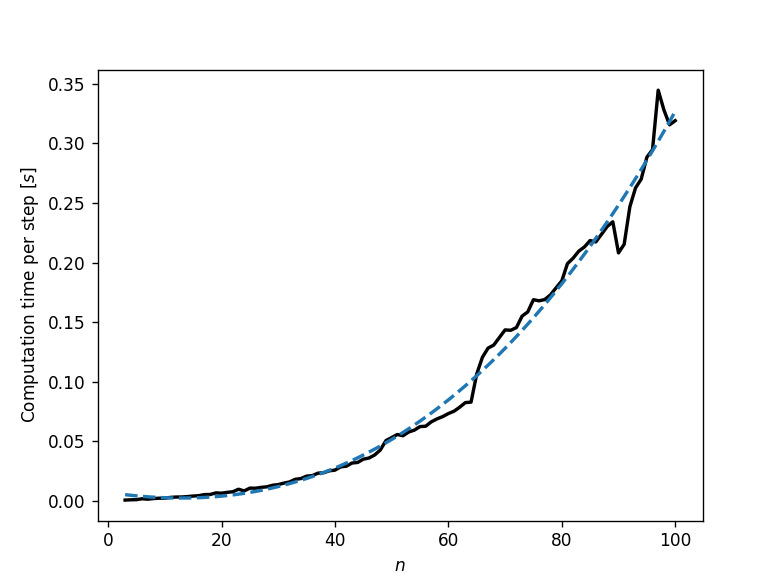

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


In [15]:
# Fit with cubic function and plot result
#
T1 = T
z = np.polyfit(dim,T, 3)
p = np.poly1d(z)
cub = p(dim)
#
plt.figure()
plt.plot(dim,T,color='k',lw=2)
plt.plot(dim,p(dim),lw=2,linestyle='dashed')
plt.xlabel(r"$n$")
plt.ylabel(r"Computation time per step [$s$]")
plt.savefig

tikz_save("comp.tex")

## Work in Progress

### Dynamic MonteCarlo (change $\delta$, $m$) 

In [16]:
# Data1 = []
# N = 30*int(1e6)
# n = 2
# par = np.array([[1.5],[1.2]])
# #
# Nm = 20
# Nd = 10
# N_mc = 120
# M = np.linspace(30,600,Nm)
# D = np.linspace(0.1,.75,Nd)
# #
# for i in tqdm(range(Nm)):
#     m = int(M[i])
#     for j in tqdm(range(Nd)):
#         delta = D[j]
#         DataI = com.BBRFmc_fix_par(N_mc,N,n,m,delta,par,6)
#         Lavg,Uavg,Lmin,Umin,Lmax,Umax,Vavg,Vmin,Vmax,Vitavg,Vitmin,Vitmax,Vtotavg,Vtotmin,Vtotmax = com.DPfix(DataI,n,N_mc)
#         V = (Uavg[-1,1]-Lavg[-1,1])*(Uavg[-1,0]-Lavg[-1,0])/DataI[0][8]
#         Data1.append([m,delta,V])

# DataB = Data1
        

In [17]:
# Data = np.array(Data)
# Mtot = M 
# Dtot = D
# for i in range(Nd-1):
#     Mtot = np.vstack((Mtot,M))
# for i in range(0,Nm-1):
#     Dtot = np.vstack((Dtot,D))

In [18]:

# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt
# from matplotlib import cm

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# X, Y, Z = axes3d.get_test_data(0.05)
# X = Mtot
# Y = np.transpose(Dtot)
# Z = np.reshape(Data[:,2],(Nm,Nd))
# # X = Data[:,0]
# # Y = Data[:,1]
# # Z = Data[:,2]


# ax.scatter(X, Y, Z)

# ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
# cset = ax.contourf(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='x', offset=10, cmap=cm.coolwarm)
# cset = ax.contourf(X, Y, Z, zdir='y', offset=1, cmap=cm.coolwarm)

# ax.set_xlabel('X')
# ax.set_xlim(M[0]-10,M[-1])
# ax.set_ylabel('Y')
# ax.set_ylim(D[0], D[-1])
# ax.set_zlabel('Z')
# ax.set_zlim(-.5, 2)

# plt.show()

In [19]:
# Data = np.array(Data)
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# #X, Y, Z = axes3d.get_test_data(0.05)
# X = Mtot
# Y = np.transpose(Dtot)
# Z = np.reshape(Data[:,2],(Nm,Nd))


# ax.scatter(X, Y, Z)

In [20]:
# plt.figure()
# plt.plot(Data[:,1],Data[:,2])

In [21]:
# Data1 = np.array(Data1)
# X = Data1[:,0]
# Y = Data1[:,1]
# Z = Data1[:,2]


# #X = np.log10(X)
# #Y = np.log10(Y)
# Z = np.log10(Z)


# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X,Y,Z)
# zticks = [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10]
# #ax.set_zticks(np.log10(zticks))
# #ax.set_zticklabels(zticks)

# #ax.plot_trisurf(Data1[:,0],Data1[:,1],Data1[:,2])
